In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import bambi as bmb
import os

In [61]:
# data = pd.read_csv('data/')#Set up plotting themes
sns.set_context('talk')
sns.set_style('darkgrid')

In [3]:
# list(data.columns)

In [4]:
def clean_data(parent_folder, filename):
    data = pd.read_csv(f'{parent_folder}/{filename}')
    graph_type = data['graph_type'][0]
    if 'walk_length' in list(data.columns):
        walk_length = data['walk_length'].unique()[0]
        if walk_length == 1000:
            walk_length = 300
    else:
        walk_length = 300
    cleaned_cat_data = data[['Prolific ID', 'test_index', 'num_feats', 'Correct Response', 'test_key_resp.corr', 'test_key_resp.rt']].dropna().reset_index(drop=True)
    cleaned_cat_data['graph_type'] = graph_type
    return cleaned_cat_data

In [6]:
filenames = [] 
for f in os.listdir('eb_cat0_order_eqfeat/data'):
    if f.startswith('undefined') and f.endswith('csv'):
        filenames.append(f)


In [8]:
df_clean = pd.concat([clean_data('eb_cat0_order_eqfeat/data', f) for f in filenames])
df_clean.to_csv('df_clean_exp4.csv')

In [10]:
df_clean = pd.read_csv('df_clean_exp4.csv')

In [152]:
df_clean.groupby(['graph_type', 'num_feats']).describe().iloc[:, -15:-13].to_latex('tables/exp4_accuracy_stats.txt', float_format="%.3f")

In [11]:
df_clean_participant = df_clean.groupby(by = ['Prolific ID', 'num_feats', 'graph_type']).mean(numeric_only=True).reset_index()

In [12]:
df_clean_participant['Prolific ID'].unique().shape

(58,)

In [13]:
df_clean_participant.loc[df_clean_participant.graph_type=='structured', 'Prolific ID'].unique().shape

(29,)

In [14]:
# df_clean['num_feats'] = 1 + (df_clean['test_index'].values/10).astype(int)

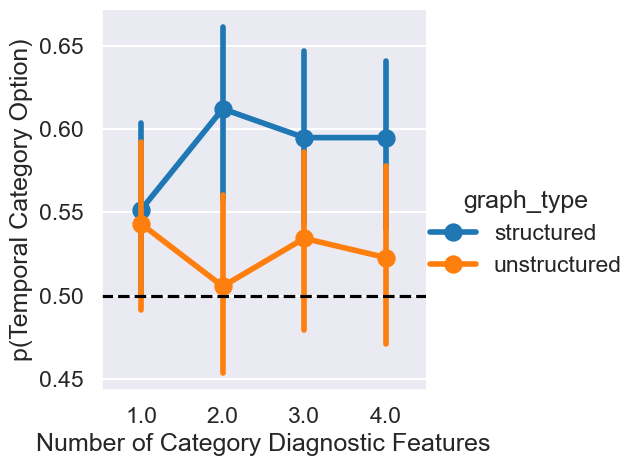

In [155]:
g = sns.catplot(x = 'num_feats', y = 'test_key_resp.corr', data = df_clean, kind = 'point', hue = 'graph_type')
g.axes[0][0].axhline(y = 0.5, ls = '--', color = 'black')
g.axes[0][0].set_ylabel('p(Temporal Category Option)')
g.axes[0][0].set_xlabel('Number of Category Diagnostic Features')
plt.savefig('figures/exp4_proportion_results.png', dpi = 300, transparent = True)


In [165]:
df_clean['participant'] = df_clean['Prolific ID']
bmb_model = bmb.Model('test_key_resp.corr ~ 0  + C(num_feats):graph_type + (1|participant)', data = df_clean, family='bernoulli')

In [171]:
bmb_model

       Formula: test_key_resp.corr ~ 0  + C(num_feats):graph_type + (1|participant)
        Family: bernoulli
          Link: p = logit
  Observations: 2784
        Priors: 
    target = p
        Common-level effects
            C(num_feats):graph_type ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0.], sigma: [7.5593 7.5593 7.5593
                7.5593 7.5593 7.5593 7.5593 7.5593])
        
        
        Group-level effects
            1|participant ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.6596))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

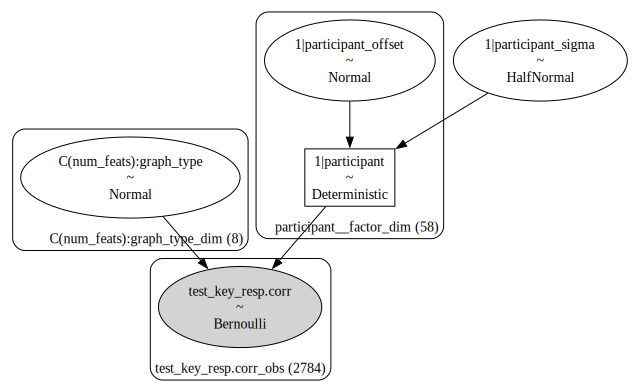

In [166]:
bmb_model.build()
bmb_model.graph()

In [167]:
samples = bmb_model.fit()

Modeling the probability that test_key_resp.corr==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C(num_feats):graph_type, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


In [159]:
az.summary(samples, var_names="graph_type", filter_vars="like").iloc[:, :4]#.to_latex('tables/exp4_bayesmodel_results.txt', float_format="%.3f")

,mean,sd,hdi_3%,hdi_97%
"C(num_feats)|graph_type[1.0, structured]",-0.127,0.170,-0.490,0.133
"C(num_feats)|graph_type[1.0, unstructured]",0.046,0.148,-0.233,0.336
"C(num_feats)|graph_type[2.0, structured]",0.132,0.176,-0.168,0.469
"C(num_feats)|graph_type[2.0, unstructured]",-0.112,0.165,-0.437,0.177
"C(num_feats)|graph_type[3.0, structured]",0.049,0.158,-0.237,0.357
"C(num_feats)|graph_type[3.0, unstructured]",0.009,0.139,-0.243,0.303
"C(num_feats)|graph_type[4.0, structured]",0.057,0.157,-0.242,0.356
"C(num_feats)|graph_type[4.0, unstructured]",-0.042,0.145,-0.309,0.259
C(num_feats)|graph_type_sigma[1.0],0.517,0.741,0.000,1.641
C(num_feats)|graph_type_sigma[2.0],0.544,0.682,0.000,1.750


In [169]:
extracted = az.extract(samples, var_names="graph_type", filter_vars="like")
extracted

<xarray.DataArray 'C(num_feats):graph_type' (C(num_feats):graph_type_dim: 8,
                                             sample: 4000)> Size: 256kB
array([[ 0.0620917 , -0.11033343, -0.42004474, ...,  0.01998215,
        -0.11099872, -0.25268221],
       [ 0.41458483,  0.85333916,  0.6515009 , ...,  0.39206106,
         0.53116991,  0.01886747],
       [ 0.15750789,  0.2220508 , -0.00552244, ...,  0.22457362,
         0.20968437, -0.01234594],
       ...,
       [ 0.64389563,  0.61689724,  0.70454588, ...,  0.53256352,
         0.30355997, -0.17682515],
       [ 0.0258288 ,  0.21516521, -0.10839518, ...,  0.20156699,
         0.06616216, -0.14648542],
       [ 0.48229644,  0.73644605,  0.69160294, ...,  0.2428573 ,
         0.44326408, -0.01826683]])
Coordinates:
  * C(num_feats):graph_type_dim  (C(num_feats):graph_type_dim) <U17 544B '1.0...
  * sample                       (sample) object 32kB MultiIndex
  * chain                        (sample) int32 16kB 0 0 0 0 0 0 ... 3 3 3 3 3 3
  * draw                         (sample) int32 16kB 0 1 2 3 ... 996 997 998 999

In [163]:
extracted.sel({'graph_type__factor_dim' :'structured', "C(num_feats)__expr_dim": f'{num_feats}'})['C(num_feats)|graph_type']

<xarray.DataArray 'C(num_feats)|graph_type' (sample: 4000)> Size: 32kB
array([0.23447795, 0.62216526, 0.36686995, ..., 0.046159  , 0.00868934,
       0.07549124])
Coordinates:
    graph_type__factor_dim  <U12 48B 'structured'
    C(num_feats)__expr_dim  <U3 12B '4.0'
  * sample                  (sample) object 32kB MultiIndex
  * chain                   (sample) int32 16kB 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3
  * draw                    (sample) int32 16kB 0 1 2 3 4 ... 996 997 998 999

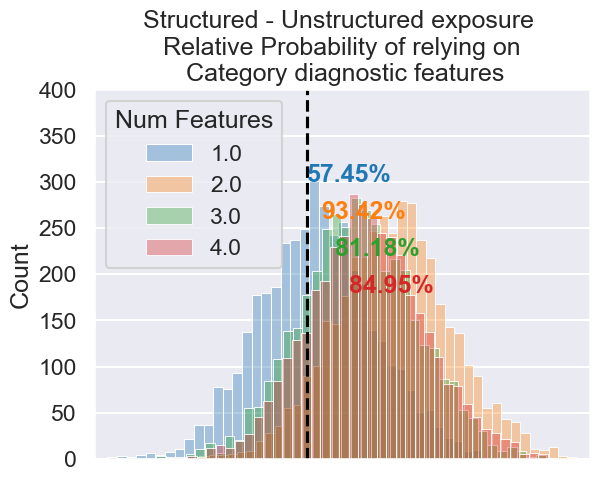

In [170]:
for i, num_feats in enumerate(['1.0', '2.0', '3.0', '4.0']):
    sns.histplot(extracted.sel({'C(num_feats):graph_type_dim' :f'{num_feats}, structured'}) - extracted.sel({'C(num_feats):graph_type_dim' :f'{num_feats}, unstructured'}), alpha = 0.35, label = f"{num_feats}")
    ge0 = np.mean(extracted.sel({'C(num_feats):graph_type_dim' :f'{num_feats}, structured'}) - extracted.sel({'C(num_feats):graph_type_dim' :f'{num_feats}, unstructured'}) > 0).values
    plt.text(x = i*0.1, y = 300 - i*40, s = f"{round(ge0*100, 2)}%", color = f"C{i}", fontweight = "heavy")

plt.legend(loc='best', title = "Num Features")#, bbox_to_anchor = (1.25, 0.5))
plt.axvline(x = 0, ls = '--', color = 'black')
plt.ylim((0, 400))
plt.xlim((-1.5, 2))
plt.xticks(ticks = [], labels=[])
plt.title('Structured - Unstructured exposure \n Relative Probability of relying on \n Category diagnostic features')

plt.savefig('figures/exp4_bayesmodel_res.png', dpi = 300, transparent = True)#, bbox_inches = 'tight')

In [140]:
extracted.sel({'C(num_feats):graph_type_dim' :f'{num_feats}, structured'}) - extracted.sel({'C(num_feats):graph_type_dim' :f'{num_feats}, unstructured'})

<xarray.DataArray 'C(num_feats):graph_type' (sample: 4000)> Size: 32kB
array([-0.11280931,  0.80423975,  0.04169005, ...,  1.28023052,
        1.33673277,  1.47287036])
Coordinates:
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int32 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int32 16kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999